In [1]:
# go wide screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Some necessary preparation

In [5]:
# Add current working directory to pythonpath
import sys
sys.path.append("/Users/mxhf/work/MPE/pfs/src/ics_cobraOps/python")

from ics.cobraOps.Bench import Bench
import pyETS


from astropy.io import ascii
import numpy as np
from collections import OrderedDict


from matplotlib import pyplot as plt
%matplotlib inline

def pp(s):
    print(s)
    return s + "\n"

# Next two lines force automatic reload of loaded module. Convenient if
# one is still fiddeling with them.
%load_ext autoreload
%autoreload 2

# Datamodel for the flow network
import pfs_netflow.datamodel as dm

# Basic Configuration

From the following three examples chosse one and execute only the corresponding cells.

In [ ]:
EXAMPLE = "COS"
#EXAMPLE = "GE"
#EXAMPLE = "GA"

## Galactic Areaology Example (UMi)

In [2]:
if EXAMPLE == "GA":
    name = "GA"

    BLOCKLENGTH = 900. # block exposure time in s
    ################################
    # Define and load target lists.
    ################################
    fscience_targets = "pfs_target_list/pfs_preliminary_target_archaeology_umi.dat"
    fcal_stars       = "pfs_target_list/pfs_preliminary_target_archaeology_umi_fcstars_mock.dat"
    fsky_pos         = "pfs_target_list/pfs_preliminary_target_archaeology_umi_sky_mock.dat"
    fsky_pos         = "pfs_target_list/pfs_preliminary_target_archaeology_umi_sky_mock_lowdensity.dat"  # lower density of sky objects

    # Load target lists.
    science_targets = ascii.read(fscience_targets)
    cal_stars = ascii.read(fcal_stars)
    sky_pos = ascii.read(fsky_pos)
    cRA  = np.median( science_targets['RA'] )  
    cDEC =  np.median( science_targets['DEC'] ) 
    RAmin,RAmax   = np.min( science_targets['RA'] ), np.max( science_targets['RA'] )
    DECmin,DECmax = np.min( science_targets['DEC'] ), np.max( science_targets['DEC'] )


    # fiducial field coortinate
    RA0, DEC0 = [np.nan, np.nan] # if set to nan, central RA and DEC of targets will be used

    # limit targets to a smaller field of view
    #DRMAX_SQ = (2700./3600.)**2. # actually the whole focal plane
    DRMAX_SQ = np.inf
    #DRMAX_SQ = (250./3600.)**2. 


    # In the case of galaxy evolution we have multiple
    # fields per target.
    # They should be optimize simultanously.
    # In each feild we will still dither around the fiducial field
    # center coordinate.

    ################################
    # Define dither pattern
    ################################
    DITHER_PATTERN = OrderedDict()
    # 12 - point round dither pattern ...
    a = np.deg2rad( np.arange(0., 360., 30) )
    r = 100. 
    xx = np.sin(a) * r/3600.
    yy = np.cos(a) * r/3600.
    for i,(x,y) in enumerate(zip(xx,yy)):
        DITHER_PATTERN['{:02d}'.format(i) ] = ( x,y)

    fields = OrderedDict()
    fields['A'] = (228.200,   +67.500)
    fields['B']  = (226.300,   +67.500)
    fields['C'] = (226.000,   +66.900)
    fields['D'] = (228.100,   +66.955)

    # more programmatic part of the configuration, load target lists
    # and comput dither positions (on sky)

    pointings = OrderedDict()
    for fid in fields:
        cRA,cDEC = fields[fid]
        for did, (offset_ra, offset_dec) in DITHER_PATTERN.items():
            pointing_RA, pointing_DEC = cRA + offset_ra/np.cos(np.deg2rad(cDEC)), cDEC + offset_dec
            pointings[ "P{}D{}".format(fid,did) ] = (pointing_RA, pointing_DEC) 

    ################################
    # Define the cost function
    ################################
    from numpy import inf

    cost_dict = {}
    # For each target class we define the 
    # cost of non-observation and non-completion 
    # as a two-tuple. The cost of non-completion 
    # is typically larger as partial completion 
    # of objects should be avoided.
    cost_dict['sci_P01'] = (1000000.,1e15)
    cost_dict['sci_P02'] = (1000000.,1e15)
    cost_dict['sci_P03'] = (1000000.,1e15)
    cost_dict['sci_P04'] = (1000000.,1e15)
    cost_dict['sci_P05'] = (1000000.,1e15)
    cost_dict['sci_P06'] = (1000.,1e15)
    cost_dict['sci_P07'] = (1000.,1e15)
    cost_dict['sci_P08'] = (1000.,1e15)
    cost_dict['sci_P09'] = (1000.,1e15)
    cost_dict['sci_P10'] = (1000.,1e15)


    # For the calibration objects we only define the cost
    # of non-observation as calibration targets only *need* to be pointinged once.
    # Note: The can of course be pointinged many times. But
    # for the calibration objects the real constraint is to have 
    # at least N out of M observed in each exposure.
    # There is no requirement to repointing a specific calibration target.
    cost_dict['cal_P01'] = 1e12
    cost_dict['sky_P01'] = 1e12

    # Here we add higher cost to later pointings. Ther should be one entry per pointing.
    cost_dict['pointings'] = OrderedDict()
    for i, pid in enumerate(pointings):
          cost_dict['pointings'][pid] = i*10.

    # Here we discourage large cobra moves. The example here is a simple
    # linear function cost = A * move_distance 
    # where the parameter A controls how quickly the cost increases as funciton of distance.
    #A = 250.
    A = 0.
    cost_dict['cobra_move'] = lambda d : d*A  


    # Here we define how at least many objects out of each class we want observed.
    supply_dict = {}
    # By setting science object to inf, we say we want them all.
    supply_dict['sci_P01'] = inf
    supply_dict['sci_P02'] = inf
    supply_dict['sci_P03'] = inf
    supply_dict['sci_P04'] = inf
    supply_dict['sci_P05'] = inf
    supply_dict['sci_P06'] = inf
    supply_dict['sci_P07'] = inf
    supply_dict['sci_P08'] = inf
    supply_dict['sci_P09'] = inf
    supply_dict['sci_P10'] = inf

    # needed calibration star per exposure
    supply_dict['cal_P01'] = 40 # inf = try to get as many as  possible
    # needed sky positions per exposure
    supply_dict['sky_P01'] = 240 # inf = try to get as many as  possible


    ################################
    # Some flags to configure behaviour
    ################################
    ENABLE_COLLISION_AVOIDANCE = False # enable endpoint collision avoidance, slow if there is many (>> 10k) targets
    ENABLE_ELBOW_COLLISION_AVOIDANCE = False
    PLOT_TARGET_DISTRIBUTION   = False
    PLOT_SURVEY_PLAN           = False # plot network of survey plan. Only use when restricting to very small subegions of the focal plane!
    PLOT_FOCAL_PLANE           = False # plot focal plane and indicate which cobras observe what targets. 
                                       # Only use when restricting to very small subegions of the focal plane!

    RANDOM_PRIORITIES          = False # Randomly assign priority classes to sciencetargets 
    MODEL_TUNING               = False # Run model tuning

    PLOT_FOCAL_PLANE_FOR_ALL_POINTINGS = False # Plot where the targets fall with respect to the cobras (and the black dots) for all pointings

## Galaxy Evolution Example

In [2]:
if EXAMPLE == "GE":
    name = "GE"
    
    ################################
    # Define target lists.
    ################################
    fscience_targets = "pfs_target_list/pfs_preliminary_target_galaxy.dat"
    fcal_stars       = "pfs_target_list/pfs_preliminary_target_galaxy_fcstars_mock.dat"
    fsky_pos         = "pfs_target_list/pfs_preliminary_target_galaxy_sky_mock.dat"
    #fsky_pos         = "pfs_target_list/pfs_preliminary_target_archaeology_umi_fcstars_mock_lowdensity.dat"


    # fiducial field coortinate
    RA0, DEC0 = [np.nan, np.nan] # if set to nan, central RA and DEC of targets will be used


    # limit targets to a smaller field of view
    #DRMAX_SQ = (2700./3600.)**2. # actually the whole focal plane
    DRMAX_SQ = np.inf


    #Define dither pattern
    DITHER_PATTERN = OrderedDict()
    # manually ...

    BIN = 2
    # dither in a hexagon ...
    a = np.deg2rad( np.linspace(0., 360., 64/BIN) )
    r = 100. 
    xx = np.sin(a) * r/3600.
    yy = np.cos(a) * r/3600.
    for i,(x,y) in enumerate(zip(xx,yy)):
        DITHER_PATTERN['D{:02d}'.format(i) ] = ( x,y)


    BLOCKLENGTH = 900.*BIN # block exposure time in s


    # more programmatic part of the configuration, load target lists
    # and comput dither positions (on sky)

    # Load target lists.
    science_targets = ascii.read(fscience_targets)
    cal_stars = ascii.read(fcal_stars)
    sky_pos = ascii.read(fsky_pos)

    # find field center and extent
    cRA  = np.median( science_targets['RA'] )  
    cDEC =  np.median( science_targets['DEC'] ) 
    RAmin,RAmax   = np.min( science_targets['RA'] ), np.max( science_targets['RA'] )
    DECmin,DECmax = np.min( science_targets['DEC'] ), np.max( science_targets['DEC'] )

    # set (or not) fiducial field center
    if [RA0, DEC0] != [np.nan, np.nan]:
        cRA, cDEC = RA0, DEC0

    pointings = OrderedDict()
    for did, (offset_ra, offset_dec) in DITHER_PATTERN.items():
        pointing_RA, pointing_DEC = cRA + offset_ra, cDEC + offset_dec
        pointings[did] = (pointing_RA, pointing_DEC) 

    ################################
    # Define the cost function
    ################################
    from numpy import inf

    cost_dict = {}
    # For each target class we define the cost 
    # of non-observation and non-completion as 
    # a two-tuple. The cost of non-completion 
    # is typically larger as partial completion 
    # of objects should be avoided.
    cost_dict['sci_P01'] = (1e10,5e10)
    cost_dict['sci_P02'] = (1e9,5e9)
    cost_dict['sci_P03'] = (1e8,5e8)
    cost_dict['sci_P04'] = (1e7,5e7)
    cost_dict['sci_P05'] = (1e6,5e6)
    cost_dict['sci_P06'] = (1e5,5e5)
    cost_dict['sci_P07'] = (1e4,5e4)
    cost_dict['sci_P08'] = (1e3,5e3)
    cost_dict['sci_P09'] = (1e2,5e2)
    cost_dict['sci_P10'] = (1e1,5e1)


    # For the calibration objects we only define the cost
    # of non-observation as calibration targets only *need* to be pointinged once.
    # Note: The can of course be pointinged many times. But
    # for the calibration objects the real constraint is to have 
    # at least N out of M observed in each exposure.
    # There is no requirement to repointing a specific calibration target.
    cost_dict['cal_P01'] = 1e11
    cost_dict['sky_P01'] = 1e11

    # Here we add higher cost to later pointings. Ther should be one entry per pointing.
    cost_dict['pointings'] = OrderedDict()
    for i, pid in enumerate(pointings):
          cost_dict['pointings'][pid] = i*1.

    # Here we discourage large cobra moves. The example here is a simple
    # linear function cost = A * move_distance 
    # where the parameter A controls how quickly the cost increases as funciton of distance.
    #A = 250.
    A = 0.1
    cost_dict['cobra_move'] = lambda d : d*A  


    # Here we define how at least many objects out of each class we want observed.
    supply_dict = {}
    # By setting science object to inf, we say we want them all.
    supply_dict['sci_P01'] = inf
    supply_dict['sci_P02'] = inf
    supply_dict['sci_P03'] = inf
    supply_dict['sci_P04'] = inf
    supply_dict['sci_P05'] = inf
    supply_dict['sci_P06'] = inf
    supply_dict['sci_P07'] = inf
    supply_dict['sci_P08'] = inf
    supply_dict['sci_P09'] = inf
    supply_dict['sci_P10'] = inf

    # need one calibration star per exposure
    supply_dict['cal_P01'] = 40 # force exactly 40
    # need one sky positions per exposure
    supply_dict['sky_P01'] = 240 # force exactly 240

    ################################
    # Some flags to configure behaviour
    ################################
    ENABLE_COLLISION_AVOIDANCE = False # enable endpoint collision avoidance, slow if there is many (>> 10k) targets
    ENABLE_ELBOW_COLLISION_AVOIDANCE = False
    PLOT_TARGET_DISTRIBUTION   = False
    PLOT_SURVEY_PLAN           = False # plot network of survey plan. Only use when restricting to very small subegions of the focal plane!
    PLOT_FOCAL_PLANE           = False # plot focal plane and indicate which cobras observe what targets. 
                                       # Only use when restricting to very small subegions of the focal plane!

    RANDOM_PRIORITIES          = False # Randomly assign priority classes to sciencetargets 
    MODEL_TUNING               = False # Run model tuning

    PLOT_FOCAL_PLANE_FOR_ALL_POINTINGS = False # Plot where the targets fall with respect to the cobras (and the black dots) for all pointings

/Users/mxhf/.pyenv/versions/3.6.0/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


## Cosmology Example

In [ ]:

if EXAMPLE == "COS":
    name = "COS"

    BLOCKLENGTH = 900. # block exposure time in s

    ################################
    # Define target lists.
    ################################
    fscience_targets = "pfs_target_list/pfs_preliminary_target_cosmology.dat"
    fcal_stars       = "pfs_target_list/pfs_preliminary_target_cosmology_fcstars.dat"
    fsky_pos         = "pfs_target_list/pfs_preliminary_target_cosmology_sky.dat"


    # fiducial field coortinate
    RA0, DEC0 = [np.nan, np.nan] # if set to nan, central RA and DEC of targets will be used


    # limit targets to a smaller field of view
    DRMAX_SQ = (2700./3600.)**2. # actually the whole focal plane
    #DRMAX_SQ = (120./3600.)**2.

    # In cosmology we don't dither, there is just one pointing, one fiber configuration,
    # and one exposure per field.
    #
    # Define dither pattern
    DITHER_PATTERN = {"A" : ( 0.,0.)} # No Dithers, just one fiducial position

    ### Only for testing performance testing against ETS
    #DITHER_PATTERN = OrderedDict()
    ## 6 - point round dither pattern ...
    #a = np.deg2rad( np.arange(0., 360., 60.) )
    #r = 10. 
    #xx = np.sin(a) * r/3600.
    #yy = np.cos(a) * r/3600.
    #for i,(x,y) in enumerate(zip(xx,yy)):
    #    DITHER_PATTERN['{:02d}'.format(i) ] = ( x,y)
    ### 

    # more programmatic part of the configuration, load target lists
    # and compute dither positions (on sky)

    # Load target lists.
    science_targets = ascii.read(fscience_targets)
    cal_stars = ascii.read(fcal_stars)
    sky_pos = ascii.read(fsky_pos)

    # find field center and extent
    cRA  = np.median( science_targets['RA'] )  
    cDEC =  np.median( science_targets['DEC'] ) 
    RAmin,RAmax   = np.min( science_targets['RA'] ), np.max( science_targets['RA'] )
    DECmin,DECmax = np.min( science_targets['DEC'] ), np.max( science_targets['DEC'] )

    # set (or not) fiducial field center
    if [RA0, DEC0] != [np.nan, np.nan]:
        cRA, cDEC = RA0, DEC0

    pointings = OrderedDict()
    for did, (offset_ra, offset_dec) in DITHER_PATTERN.items():
        pointing_RA, pointing_DEC = cRA + offset_ra, cDEC + offset_dec
        pointings[did] = (pointing_RA, pointing_DEC) 

    # EXPERIMENT: HIGHEST COST/LOWEST COST SHOULD BE < 1e12.
    # Adjust cost and dscourage wide moves.

    ################################
    # Define the cost function
    ################################
    from numpy import inf

    cost_dict = {}
    # For each target class we define the cost 
    # of non-observation and non-completion as 
    # a two-tuple. The cost of non-completion 
    # is typically larger as partial completion 
    # of objects should be avoided.
    cost_dict['sci_P01'] = (1e2,1e4)


    # For the calibration objects we only define the cost
    # of non-observation as calibration targets only *need* to be pointinged once.
    # Note: The can of course be pointinged many times. But
    # for the calibration objects the real constraint is to have 
    # at least N out of M observed in each exposure.
    # There is no requirement to repointing a specific calibration target.
    cost_dict['cal_P01'] = 1e6
    cost_dict['sky_P01'] = 1e6

    # Here we add higher cost to later pointings. Ther should be one entry per pointing.
    cost_dict['pointings'] = OrderedDict()
    for i, pid in enumerate(pointings):
          cost_dict['pointings'][pid] = i*10.

    # Here we discourage large cobra moves. The example here is a simple
    # linear function cost = A * move_distance 
    # where the parameter A controls how quickly the cost increases as funciton of distance.
    #A = 250.
    #A = 10.
    A = 0.1
    cost_dict['cobra_move'] = lambda d : d*A  


    # Here we define how at least many objects out of each class we want observed.
    supply_dict = {}
    # By setting science object to inf, we say we want them all.
    supply_dict['sci_P01'] = inf

    # need one calibration star per exposure
    supply_dict['cal_P01'] = 11 # force exactly 11
    # need one sky positions per exposure
    supply_dict['sky_P01'] = 328 # force exactly 328
    
    ################################
    # Some flags to configure behaviour
    ################################
    ENABLE_COLLISION_AVOIDANCE = False # enable endpoint collision avoidance, slow if there is many (>> 10k) targets
    ENABLE_ELBOW_COLLISION_AVOIDANCE = False
    PLOT_TARGET_DISTRIBUTION   = False
    PLOT_SURVEY_PLAN           = False # plot network of survey plan. Only use when restricting to very small subegions of the focal plane!
    PLOT_FOCAL_PLANE           = False # plot focal plane and indicate which cobras observe what targets. 
                                       # Only use when restricting to very small subegions of the focal plane!

    RANDOM_PRIORITIES          = False # Randomly assign priority classes to sciencetargets 
    MODEL_TUNING               = False # Run model tuning

    PLOT_FOCAL_PLANE_FOR_ALL_POINTINGS = False # Plot where the targets fall with respect to the cobras (and the black dots) for all pointings

## General Configuration items

In [16]:
# You can limit the problem here by constraining it to a subregion of the focal plane

# good very minimal example
#RMAX   = 10.
#CENTER = [-0.,0.]
#fieldsize   = "tinytiny"

# check for changing visibility
#RMAX   = 10.
#CENTER = [7.,-12.]
#fieldsize   = "tiny"

# intermediate example
#RMAX   = 150.
#CENTER = [0.,0.]
#fieldsize   = "intermediate"

# good small example!
#RMAX   = 25.
#CENTER = [-0.,0.]
#fieldsize   = "small"

# do them all!
RMAX   = 310.
CENTER = [-0.,0.]
fieldsize   ="all"

# Read the catalogs, compute visibility ... 

In [6]:
# Convert data to lists for ETS and (mayby) apply radial cut.
import numpy as np
from numpy import hstack
from numpy import cos, deg2rad, sqrt
from numpy import unique, array
from collections import OrderedDict


ID         = hstack([science_targets['ID'],cal_stars['ID'],sky_pos['ID']])
ra         = hstack([science_targets['RA'],cal_stars['RA'],sky_pos['RA']])
dec        = hstack([science_targets['DEC'],cal_stars['DEC'],sky_pos['DEC']])
exp_times  = hstack([science_targets['EXP_TIME'],cal_stars['EXP_TIME'],sky_pos['EXP_TIME']])
priorities = hstack([science_targets['Priority'],cal_stars['Priority'],sky_pos['Priority']])

# make up target classes from target type and priority
types = ["sci"]*len(science_targets) + ["cal"]*len(cal_stars) + ["sky"]*len(sky_pos)
class_dict = {}
for id,t,p in zip(ID, types, priorities):
    class_dict[id] = '{}_P{:02d}'.format(t, p)


dra = (ra - cRA)*cos(deg2rad(cDEC))
ddec = dec - cDEC
ii = (dra**2. + ddec **2.) <= DRMAX_SQ

ID = ID[ii].tolist()
ra = ra[ii].tolist()
dec = dec[ii].tolist()
exp_times = exp_times[ii].tolist()
priorities = priorities[ii].tolist()
types = np.array(types)[ii].tolist()

c = np.array([ class_dict[t][:3] for t in ID ])
ii_sci = c == 'sci'
ii_cal = c == 'cal'
ii_sky = c == 'sky'

print( "{} science targets, {} calibration targets, and {} sky positions survive radial cut.".format(sum(ii_sci),sum(ii_cal),sum(ii_sky)))

120297 science targets, 500 calibration targets, and 20000 sky positions survive radial cut.


In [7]:
print ("Priority classes: ", np.unique(priorities))
# assign random priorities between 1 and 3 for the  science targets
if RANDOM_PRIORITIES:
    # Kohei's catalog already does come with priorities
    from numpy import random
    from numpy import array

    random.seed(42)

    N =  sum(ii_sci) 

    newpri = array( random.uniform(1.,4., size=N) , dtype=int)
    priorities = np.array(priorities)

    priorities[ii_sci] = newpri
    priorities = priorities.tolist()

Priority classes:  [1 2 3 4 5 6]


In [8]:
# compute number of required visists from exposure times
# and block length
nreqv_dict = {}
for id,t,nrv in zip(ID, types, array(exp_times)/BLOCKLENGTH):
    nreqv_dict[id] = max( int(nrv), 1)
    
print( "Unique sequence of required repointings", unique( [v for v in nreqv_dict.values()] ))

Unique sequence of required repointings [ 1  4  6 10 12 32]


In [9]:
# RANDOMISE NUMBER OF REQUIRED VISISTS
RANDOMIZENREQ = False

if RANDOMIZENREQ:
    from numpy import random
    
    NPOINTINGS = 10
    nv = np.floor( random.uniform(NPOINTINGS+1, size=len(ID)) ) 

    # compute number of required visists from exposure times
    # and block length
    nreqv_dict = {}
    for id,t,nrv in zip(ID, types, nv):
        nreqv_dict[id] = int(nrv)

    print( "Required repointings", unique( [v for v in nreqv_dict.values()] ))

In [10]:
import pyETS
import pycconv

# Temporary, very crude method to convert Ra/Dec pairs to x/y coordinates
# on the focal plane. To be replaced by the official functionality once
# available.
# All input angles are expected in degrees.
def radec2pos(ras, decs, raTel=None, decTel=None, posang=0.,
              time="2016-04-03T08:00:00Z"):
    if raTel is None:
        raTel = np.average(ras)
    if decTel is None:
        decTel = np.average(decs)
    return pycconv.cconv(ras,decs,raTel,decTel,posang+90.,time)

# get a data structure containing the idealized cobras
ets_cobras = pyETS.getAllCobras()

# for every pointing, compute target positions
# in the focal plane 
# and a visibilty map
visibility_maps = OrderedDict()
ets_target_pos  = OrderedDict()
for pid,(pointing_RA,pointing_DEC) in pointings.items():
    # Parse a target file and return the quantities of interest
    ets_target_pos[pid] = radec2pos(ra, dec, raTel=pointing_RA, decTel=pointing_DEC)

    # get a list of targets, and a list of Cobras that can observe them
    # keys contain object index
    # values contain indices of cobras that can observe that object.
    visibility_maps[pid] = pyETS.getVis(ets_target_pos[pid], ets_cobras)

In [11]:
#Interface to the new ETS, convert cobras, visibilities and targets to old style format
from collections import OrderedDict

# obtain cobra centers in old ETS dictionary style
cobras = OrderedDict()
for i,c in enumerate(ets_cobras):
        x,y = np.real( ets_cobras[i][0] ), np.imag( ets_cobras[i][0] )
        cobras["{:d}".format(i)] = [x,y]
        
# obtain dot centers in dictionary style
dots = OrderedDict()
for i,c in enumerate(ets_cobras):
        x,y = np.real( ets_cobras[i][-2] ), np.imag( ets_cobras[i][-2] )
        r = ets_cobras[i][-1]
        dots["{:d}".format(i)] = [x,y,r]


# obtain target positions in old ETS dictionary style
target_fplane_pos = OrderedDict()
for pid in ets_target_pos:
    tt = OrderedDict()
    for j,c in enumerate(ets_target_pos[pid]):
            x,y = np.real(c),np.imag(c)
            tt[ID[j]] = [float(x),float(y)]
    target_fplane_pos[pid] = tt

# obtain visibilities in old ETS dictionary style
visibilities = OrderedDict()
for pid in visibility_maps:
    vv = OrderedDict()   
    for v in visibility_maps[pid]:
        t = ID[v]
        cc = ["{:d}".format(c) for c in visibility_maps[pid][v]]
        vv[t] = cc
    visibilities[pid] = vv    

In [12]:
if PLOT_FOCAL_PLANE_FOR_ALL_POINTINGS:
    from pfs_netflow.plotting import plotFP
    #plotFP(cobras,dots,target_fplane_pos,maxx=20.,maxy=20.)

In [13]:
if PLOT_TARGET_DISTRIBUTION:
    from pfs_netflow.plotting import plotTargetDistribution
    plotTargetDistribution(ra, dec, types, pointings, target_fplane_pos, class_dict)

# Invert visibilities

In [14]:
# Compute a few statistics:
# Number of rachable targets by type and
# number of cobras that can observe any target.
def invert_vis(visibilities):
    """
    Invert visibility map, i.e. for each cobra list the observable targets
    """
    ivisibilities = OrderedDict()
    for pid in visibilities:
        cnt = 0
        ivisibilities[pid] = OrderedDict()
        for v in visibilities[pid]:
            t = v
            cc = visibilities[pid][v]

            for c in cc:
                if c in ivisibilities[pid]:
                    ivisibilities[pid][c].append(v)
                else:
                    ivisibilities[pid][c] = [v]

    return ivisibilities

def computeObservabityStats(visibilities):
    ivisibilities = invert_vis(visibilities)           

    for pid in visibilities:
        print("Pointing {}".format(pid))
        nsci_observable = 0
        ncal_observable = 0
        nsky_observable = 0

        for tid,v in visibilities[pid].items():
            if len(v) > 0:
                if class_dict[tid][:3] == 'cal':
                    ncal_observable += 1
                elif class_dict[tid][:3] == 'sky':
                    nsky_observable += 1
                elif class_dict[tid][:3] == 'sci':
                    nsci_observable += 1
                #break


        print(" {} targets positions in total.".format(sum(ii_sci) ))
        print(" {} cal. targets in total.".format(sum(ii_cal) ))
        print(" {} sky positions in total.".format(sum(ii_sky) ))
        print(" {:6d} cobras have at least one target in reach.".format(len(ivisibilities[pid])))
        print(" {:6d} science targets\n {:6d} calibration targets,\n {:6d} sky positions \nare in reach of at least one cobra."\
              .format(nsci_observable, ncal_observable, nsky_observable))  
        print("")
     
ivisibilities = invert_vis(visibilities)
computeObservabityStats(visibilities)

Pointing D00
 120297 targets positions in total.
 500 cal. targets in total.
 20000 sky positions in total.
   2394 cobras have at least one target in reach.
  22513 science targets
     55 calibration targets,
   2468 sky positions 
are in reach of at least one cobra.

Pointing D01
 120297 targets positions in total.
 500 cal. targets in total.
 20000 sky positions in total.
   2393 cobras have at least one target in reach.
  22523 science targets
     52 calibration targets,
   2446 sky positions 
are in reach of at least one cobra.

Pointing D02
 120297 targets positions in total.
 500 cal. targets in total.
 20000 sky positions in total.
   2394 cobras have at least one target in reach.
  22500 science targets
     52 calibration targets,
   2435 sky positions 
are in reach of at least one cobra.

Pointing D03
 120297 targets positions in total.
 500 cal. targets in total.
 20000 sky positions in total.
   2392 cobras have at least one target in reach.
  22445 science targets
     

 120297 targets positions in total.
 500 cal. targets in total.
 20000 sky positions in total.
   2394 cobras have at least one target in reach.
  22513 science targets
     55 calibration targets,
   2468 sky positions 
are in reach of at least one cobra.



# Execute netflow

In [18]:
# Build the survey plan graph.

from numpy import inf
from pfs_netflow.survey_plan import buildSurveyPlan
from pfs_netflow.plotting import plotSurveyPlan

print("Creating graph ...")

# for per-ponting list of targets, build
# single list of targets with multiple entries for the focal plane positions
targets = OrderedDict()
for pid in target_fplane_pos:
    tt = target_fplane_pos[pid] 
    for tid in tt:
        x,y = tt[tid]
        if not tid in targets:
             targets[tid] = OrderedDict()
        targets[tid][pid] = (x,y)
        

# build the survey plan graph
g = buildSurveyPlan(cobras, targets, nreqv_dict, visibilities, class_dict,\
                    cost_dict, supply_dict, RMAX, CENTER=(0.,0.), COBRAS=[])

print("Done.")

for pid in pointings:
    print("Pointing {}".format(pid))
    for c in g.sciTargetClasses:

        nsci = 0
        nsci_reachable = 0
        for t in g.sciTargetClasses[c].targets.values():
            if t.outarcs != []:
                nsci += 1
                nsci_reachable += 1

        print("   Number of targets in {} is {}.".format(c, nsci ) )
        print("   Number of observable targets in {} is {}.".format(c, nsci_reachable ) )


    ncal = 0
    ncal_reachable = 0
    for t in g.calTargetClasses['TClass_cal_P01_v{}'.format(pid)].targets.values():
        if t.outarcs != []:
            ncal += 1
            ncal_reachable += 1
    print("   Number of calibration stars: {}".format(ncal) )
    print("   Number of observable calibration stars: {}".format( ncal_reachable )) 


    nsky = 0
    nsky_reachable = 0
    for t in g.calTargetClasses['TClass_sky_P01_v{}'.format(pid)].targets.values():
        if t. outarcs != []:
            nsky += 1
            nsky_reachable += 1
    print("   Number of sky positions: {}".format(nsky) )
    print("   Number of observable sky positions: {}".format(nsky_reachable) )



Creating graph ...
buildSurveyPlan
Done.
Pointing D00
   Number of targets in TClass_sci_P01 is 418.
   Number of observable targets in TClass_sci_P01 is 418.
   Number of targets in TClass_sci_P02 is 226.
   Number of observable targets in TClass_sci_P02 is 226.
   Number of targets in TClass_sci_P03 is 189.
   Number of observable targets in TClass_sci_P03 is 189.
   Number of targets in TClass_sci_P04 is 7262.
   Number of observable targets in TClass_sci_P04 is 7262.
   Number of targets in TClass_sci_P05 is 44330.
   Number of observable targets in TClass_sci_P05 is 44330.
   Number of targets in TClass_sci_P06 is 5298.
   Number of observable targets in TClass_sci_P06 is 5298.
   Number of calibration stars: 55
   Number of observable calibration stars: 55
   Number of sky positions: 2468
   Number of observable sky positions: 2468
Pointing D01
   Number of targets in TClass_sci_P01 is 418.
   Number of observable targets in TClass_sci_P01 is 418.
   Number of targets in TClass_s

   Number of targets in TClass_sci_P04 is 7262.
   Number of observable targets in TClass_sci_P04 is 7262.
   Number of targets in TClass_sci_P05 is 44330.
   Number of observable targets in TClass_sci_P05 is 44330.
   Number of targets in TClass_sci_P06 is 5298.
   Number of observable targets in TClass_sci_P06 is 5298.
   Number of calibration stars: 55
   Number of observable calibration stars: 55
   Number of sky positions: 2484
   Number of observable sky positions: 2484
Pointing D12
   Number of targets in TClass_sci_P01 is 418.
   Number of observable targets in TClass_sci_P01 is 418.
   Number of targets in TClass_sci_P02 is 226.
   Number of observable targets in TClass_sci_P02 is 226.
   Number of targets in TClass_sci_P03 is 189.
   Number of observable targets in TClass_sci_P03 is 189.
   Number of targets in TClass_sci_P04 is 7262.
   Number of observable targets in TClass_sci_P04 is 7262.
   Number of targets in TClass_sci_P05 is 44330.
   Number of observable targets in 

   Number of observable targets in TClass_sci_P03 is 189.
   Number of targets in TClass_sci_P04 is 7262.
   Number of observable targets in TClass_sci_P04 is 7262.
   Number of targets in TClass_sci_P05 is 44330.
   Number of observable targets in TClass_sci_P05 is 44330.
   Number of targets in TClass_sci_P06 is 5298.
   Number of observable targets in TClass_sci_P06 is 5298.
   Number of calibration stars: 59
   Number of observable calibration stars: 59
   Number of sky positions: 2454
   Number of observable sky positions: 2454
Pointing D24
   Number of targets in TClass_sci_P01 is 418.
   Number of observable targets in TClass_sci_P01 is 418.
   Number of targets in TClass_sci_P02 is 226.
   Number of observable targets in TClass_sci_P02 is 226.
   Number of targets in TClass_sci_P03 is 189.
   Number of observable targets in TClass_sci_P03 is 189.
   Number of targets in TClass_sci_P04 is 7262.
   Number of observable targets in TClass_sci_P04 is 7262.
   Number of targets in TC

In [20]:
# now build the LP problem
from pfs_netflow.lp import buildLPProblemGRB
from pfs_netflow.lp import setflows
import time
    
NCobras = len(g.cobras)
NSciTargets = len(g.sciTargets)
NCalTargets = len(g.calTargets)
NPOINTINGS = len( g.pointings )

summary = ""
summary += pp("NPOINTINGS = {}".format(NPOINTINGS))
summary += pp("Searching optimal strategy to observe in ")
summary += pp(" {} pointings".format(NPOINTINGS))
summary += pp(" {} science targets".format(NSciTargets))
summary += pp(" {} calib. targets".format(int(NCalTargets/NPOINTINGS) ))
summary += pp(" {} cobras".format(NCobras))
summary += pp("num nodes: {}".format(len(g.nodes)))
summary += pp("num edges: {}".format(len(g.arcs)))

summary += pp("Building LP problem ...")
start_time = time.time()
model, flows, cost = buildLPProblemGRB(g, name=name)
time_to_build = time.time() - start_time
summary += pp("Time to build model: {:.4e} s".format(time_to_build))

model.write("mps/{}_{}_{}_{}.mps.gz".format(name, fieldsize, RMAX, NPOINTINGS))

NPOINTINGS = 32
Searching optimal strategy to observe in 
 32 pointings
 57723 science targets
 6383 calib. targets
 2394 cobras
num nodes: 2188188
num edges: 3271927
Building LP problem ...
Building cost equation ...
 Time to completion: 105.45 s
Time to build model: 1.1097e+02 s


In [63]:
#model.read("prm/GE_tune_000.prm")

In [64]:
### Endpoint fiber to fiber collision avoidance

ENABLE_COLLISION_AVOIDANCE = False

from gurobipy import quicksum
from pfs_netflow.survey_plan import compute_collision_pairs, compute_collision_flow_pairs
  
if ENABLE_COLLISION_AVOIDANCE:
    collision_pairs = compute_collision_pairs(pointings, target_fplane_pos) 
    
    flow_pairs = compute_collision_flow_pairs(g, collision_pairs)
    print("Adding {} collision avoidance constraints.".format(len(flow_pairs)))              
    for fp in flow_pairs:
        if fp[0] in flows and fp[1] in flows:
            model.addConstr( quicksum( [ flows[ fp[0] ], flows[ fp[1] ] ] ) <= 1. )

filename = "mps/{}_{}_{}_{}.mps.gz".format(name, fieldsize, RMAX, NPOINTINGS, rename=1)
model.write(filename)

In [65]:
### Endpoint fiber to fiber, fiber to elbow, elbow to elbow collision avoidance

ENABLE_ELBOW_COLLISION_AVOIDANCE = False



if ENABLE_ELBOW_COLLISION_AVOIDANCE:
    elbowPositions = ics_interface.getElbowPositions(g, ivisibilities)

    collision_flow_pairs = ics_interface.compute_collision_flow_pairs(g, elbowPositions, fiber_collision_radius = 1.0) # 1.074 is good

    ics_interface.addCollisionFlowConstraints(model, flows, collision_flow_pairs)

    filename = "mps/{}_{}_{}_{}.mps.gz".format(name, fieldsize, RMAX, NPOINTINGS, rename=1)
    model.write(filename)

Computing potential cobra elbow positions ...
Number of cobras: 2394
Finding fiber-fiber, fiber-elbow, and elbow-elbow collisions ...
Pointing A: Found  23281 collision pairs.
Adding flow constraints to model ...
Added 23281 collision flow constraints.


In [ ]:
model.Params.timelimit = 600000.0
model.Params.Threads = 7
model.Params.MIPGap = 3e-3

In [ ]:
from numpy import random

# solve it!

random.seed(42)

# Solve problem!
summary += pp("Solving LP problem ...")
start_time = time.time()

#maxSeconds=2400.
#status = solve(prob, maxSeconds=maxSeconds)
model.optimize()

time_to_solve = time.time() - start_time
summary += pp("Solve status is [{}].".format( model.status ))
summary += pp("Time to solve: {:.4e} s".format(time_to_solve))

setflows(model, g, flows)

Solving LP problem ...
Optimize a model with 2185794 rows, 3271928 columns and 9285071 nonzeros
Variable types: 1 continuous, 3271927 integer (3214134 binary)
Coefficient statistics:
  Matrix range     [3e-04, 1e+11]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+06]
  RHS range        [4e+01, 4e+04]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 1857962 rows and 1981309 columns (presolve time = 5s) ...
Presolve removed 1857987 rows and 1981309 columns (presolve time = 11s) ...
Presolve removed 1857987 rows and 1981309 columns (presolve time = 22s) ...
Presolve removed 1858072 rows and 1981469 columns
Presolve time: 24.49s
Presolved: 327722 rows, 1290459 columns, 2525090 nonzeros
Variable types: 0 continuous, 1290459 integer (1262703 binary)
Found heuristic solution: objective 1.023616e+15

Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log on

   217   216 2.2083e+12   24 30908 2.2094e+12 2.2083e+12  0.05%   520 1588s
   274   277 2.2083e+12   35 30729 2.2094e+12 2.2083e+12  0.05%   423 1635s
H  287   289                    2.209358e+12 2.2083e+12  0.05%   407 1635s
H  333   332                    2.209228e+12 2.2083e+12  0.04%   360 1636s
   340   337 2.2083e+12   43 30544 2.2092e+12 2.2083e+12  0.04%   355 1690s
   448   431 2.2084e+12   53 30405 2.2092e+12 2.2083e+12  0.04%   292 1766s
   483   464 2.2084e+12   56 30375 2.2092e+12 2.2083e+12  0.04%   394 1842s
   586   567 2.2084e+12   64 30358 2.2092e+12 2.2083e+12  0.04%   360 1925s
   711   689 2.2084e+12   76 29767 2.2092e+12 2.2083e+12  0.04%   327 2045s
H  723   605                    2.208978e+12 2.2083e+12  0.03%   414 2124s
H  724   603                    2.208965e+12 2.2083e+12  0.03%   425 2124s
   762   635 2.2084e+12   78 29664 2.2090e+12 2.2083e+12  0.03%   452 2237s
H  846   717                    2.208955e+12 2.2083e+12  0.03%   455 2399s
H  848   710     

In [68]:
from pfs_netflow.survey_plan import computeStats

stats = computeStats(g)

obj = model.getObjective()
summary += pp("{} = {}".format('Value of cost function', obj.getValue() ) )
summary += pp("[{}] out of {} science targets get observed.".format(int(stats['NSciObs']) ,NSciTargets) )
summary += pp("For {} out of these all required exposures got allocated.".format(stats['NSciComplete']))  
summary += pp("Per target class completion:")
                                                            
summary += pp("   {:15s} {:10s} {:10s} {:10s}".format('class', 'total', 'observed', 'completed') )
for tc,compl in stats['completion'].items():
    summary += pp("   {:15s} {:10d} {:10d} {:10d}".format(tc, compl['total'],compl['observed'],compl['completed']))                                                                       
    #print(tc, compl)                                                                  
summary += pp("{} targets get sent down the overflow arc.".format(stats['Noverflow']))
summary += pp("{} out of {} cobras observed a target in one or more exposures.".format(stats['Ncobras_used'], NCobras ))
summary += pp("{} cobras observed a target in all exposures.".format(stats['Ncobras_fully_used']))



Value of cost function = 5053202.63880438
[2004] out of 12531 science targets get observed.
For 2004 out of these all required exposures got allocated.
Per target class completion:
   class           total      observed   completed 
   TClass_sci_P01       12531       2004       2004
10527 targets get sent down the overflow arc.
2339 out of 2394 cobras observed a target in one or more exposures.
2339 cobras observed a target in all exposures.


# Check up on collisions 

In [69]:
# Simple fiber to fiber collision detection

# test if really no colliding targets were observed
# This needs to be added to the survey plan and buildLPProblem methods.
#

from pfs_netflow.survey_plan import compute_collision_pairs, compute_collision_flow_pairs

if not 'collision_pairs' in vars():
    collision_pairs = compute_collision_pairs(pointings, target_fplane_pos) 

flow_pairs = compute_collision_flow_pairs(g, collision_pairs)
 
NCOLL = 0
for fp in flow_pairs:
    f1 = g.arcs[ fp[0] ].flow
    f2 = g.arcs[ fp[1] ].flow
    
    if f1 > 0. and f2 > 0.:
        #print("{} {} in collision".format(fp[0],fp[1]))
        NCOLL += 1
                             
print("Detected {} fiber to fiber endpoint collisions".format(NCOLL))

Detected 0 fiber to fiber endpoint collisions


In [70]:
# Trajectory collision detection

import numpy as np
import time as time

sys.path.append("/Users/mxhf/work/MPE/pfs/src/ics_cobraOps/python")

import ics.cobraOps.plotUtils as plotUtils
import ics.cobraOps.targetUtils as targetUtils

from ics.cobraOps.Bench import Bench
from ics.cobraOps.CobrasCalibrationProduct import CobrasCalibrationProduct
from ics.cobraOps.CollisionSimulator import CollisionSimulator
from ics.cobraOps.DistanceTargetSelector import DistanceTargetSelector
from ics.cobraOps.RandomTargetSelector import RandomTargetSelector
from ics.cobraOps.TargetGroup import TargetGroup

def getBench(g):
    # convert cobra positions to array of complex numbers
    cids = [  c.id for c in g.cobras.values() ]
    
    cpos = np.array( [ complex(g.cobras[cid].getX(pid) , g.cobras[cid].getY(pid)) for cid in cids] )
    # and create bench object
    bench = Bench(cobraCenters=np.array( cpos ))
    print("Number of cobras:", bench.cobras.nCobras)
    return bench

def getCollSim(g, pid, bench, PLOT=False, PLOTTRAJ=False, ZOOMIN=False):
    # initialize assigment list with Null
    # as required by the collision simulator code.
    assignments = OrderedDict()
    for c in g.cobras.values(): 
        assignments[c.id] = ('NULL',0.+0.j)

    # Now find which cobras have been assigned to which targets. 
    # Loop over all targetPointing to CobraPointing arcs.Filter for those that correspond to the current pointing.
    for a in filter(lambda x : x.pointing == pid, g.targetPointingToCobraPointingArcs.values()):
        if a.flow > 0.:
            t = a.startnode.target
            c = a.endnode.cobra 
            #assignments[c.id] = t.id
            assignments[c.id] = (t.id, complex(t.getX(pid), t.getY(pid)) )

    # convert cobra positions to array of complex numbers
    cids = [ cid for cid in assignments]
    cpos = np.array( [ complex(g.cobras[cid].getX(pid) , g.cobras[cid].getY(pid)) for cid in assignments] )
    # and create bench object
    #bench = Bench(cobraCenters=np.array( cpos ))
    print("Number of cobras:", bench.cobras.nCobras)

    # Create list of fiber to cobra assignments
    targetpos       = np.array([t[1] for t in assignments.values()])
    ids             = np.array([t[0] for t in assignments.values()])
    selectedTargets = TargetGroup(positions=targetpos, ids=ids)
    print("Number of  targets:", selectedTargets.nTargets)


    # Simulate an observation
    start = time.time()
    simulator = CollisionSimulator(bench, selectedTargets)
    simulator.run()
    print("Number of cobras involved in collisions:", simulator.nCollisions)
    print("Number of colliding cobras that are not also end collisions: ", simulator.nCollisions - simulator.nEndPointCollisions)
    print("Total simulation time (s):", time.time() - start)

    if PLOT:
        # Plot the simulation results
        __ = simulator.plotResults(paintFootprints=False, size=(10,10))

        W = 200
        xc = -75.
        yc =  20.
        xmin,xmax = -W/2.+xc,W/2.+xc
        ymin,ymax = -W/2.+yc,W/2.+yc

        #for i,(x,y) in enumerate(zip( np.real( targetpos ), np.imag( targetpos ) ) ):
        #    if xmin < x and x < xmax and ymin < y and y < ymax:
        #        plt.text(x,y,ids[i], size=12)

        if ZOOMIN:
            plt.xlim([xmin,xmax])
            plt.ylim([ymin,ymax])



    if PLOTTRAJ:
        # Animate one of the trajectory collisions
        (problematicCobras,) = np.where(np.logical_and(simulator.collisions, simulator.endPointCollisions == False))

        if len(problematicCobras) > 0:
            simulator.animateCobraTrajectory(problematicCobras[0])
        else:
            print("No trajectory collisions detected...")

        # Pause the execution to have time to inspect the figures
        plotUtils.pauseExecution()
        
    return simulator, assignments, cids
    
#pid = list(g.pointings)[0]
#simulator, assignments, cids = getCollSim(g, pid)



In [75]:
from pfs_netflow import ics_interface
import random
random.seed(42)

## only for debugging of restarts
model.reset()
model, flows, cost = buildLPProblemGRB(g, name=name)

COLLISION_AVOIDANCE = True
if COLLISION_AVOIDANCE:
    elbowPositions = ics_interface.getElbowPositions(g, ivisibilities)
    collision_flow_pairs = ics_interface.compute_collision_flow_pairs(g, elbowPositions, fiber_collision_radius = .8) # 1.074 is good
    ics_interface.addCollisionFlowConstraints(model, flows, collision_flow_pairs)

filename = "mps/{}_{}_{}_{}_colliter{:02d}.mps.gz".format(name, fieldsize, RMAX, NPOINTINGS, 0)
model.write(filename)
    
model.optimize()

model.write(filename.replace(".mps",".sol"))
setflows(model, g, flows)

Building cost equation ...
 Time to completion: 1.13 s
Computing potential cobra elbow positions ...
Number of cobras: 2394
Finding fiber-fiber, fiber-elbow, and elbow-elbow collisions ...
Pointing A: Found  16143 collision pairs.
Adding flow constraints to model ...
Added 16143 collision flow constraints.
Optimize a model with 44190 rows, 51464 columns and 143705 nonzeros
Variable types: 1 continuous, 51463 integer (38929 binary)
Coefficient statistics:
  Matrix range     [2e-03, 1e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+06]
  RHS range        [1e+00, 1e+04]
Found heuristic solution: objective 3.57376e+08
Presolve removed 44163 rows and 51418 columns
Presolve time: 0.12s
Presolved: 27 rows, 46 columns, 88 nonzeros
Found heuristic solution: objective 2053204.0322
Variable types: 0 continuous, 46 integer (45 binary)

Root relaxation: cutoff, 20 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  

In [76]:
# create bench instance
bench = getBench(g)

Number of cobras: 2394


In [77]:
# Compute fffor each cobra its neighbors
R = 15.
cxx = np.array( [c.getX(pid) for c in g.cobras.values()] )
cyy = np.array( [c.getY(pid) for c in g.cobras.values()] )
cc  = np.array( [c for c in g.cobras.values()] )

for c in g.cobras.values():
    dd_sq = (c.getX(pid) - cxx)**2 + (c.getY(pid) - cyy)**2
    ii = dd_sq <= R**2.
    c.neighbor_cobras = cc[ii]

mdn = np.median( [ len(c.neighbor_cobras) for c in g.cobras.values()] )
print("Median number of neighbors is {}.".format(mdn))

Median number of neighbors is 13.0.


###########################################
Iteration 1 ...
###########################################
Number of cobras: 2394
Number of  targets: 2394
Number of cobras involved in collisions: 8
Number of colliding cobras that are not also end collisions:  0
Total simulation time (s): 0.7984280586242676
T_C040789_vA=C_799_vA :  1.0     T_C040788_vA=C_801_vA :  1.0
T_C036781_vA=C_1750_vA :  1.0     T_C036785_vA=C_1752_vA :  1.0
T_C013686_vA=C_2148_vA :  1.0     T_C013692_vA=C_2149_vA :  1.0
T_C013679_vA=C_2212_vA :  1.0     T_C011838_vA=C_2213_vA :  1.0
Adding flow constraints to model ...
Added 4 collision flow constraints.
Solving LP problem ...
Optimize a model with 44194 rows, 51464 columns and 143713 nonzeros
Variable types: 1 continuous, 51463 integer (38929 binary)
Coefficient statistics:
  Matrix range     [2e-03, 1e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+06]
  RHS range        [1e+00, 1e+04]

MIP start did not produce a new incumbent solution
MIP st

/Users/mxhf/.pyenv/versions/3.6.0/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


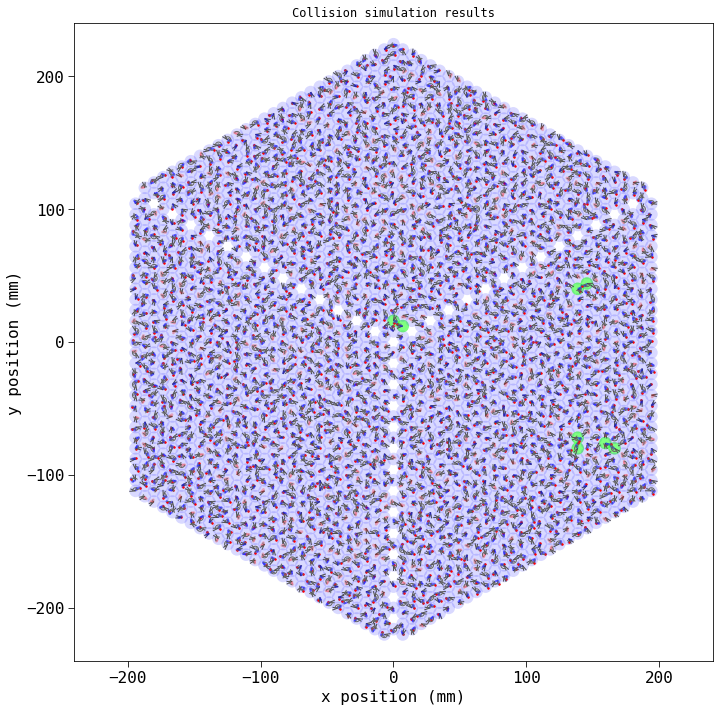

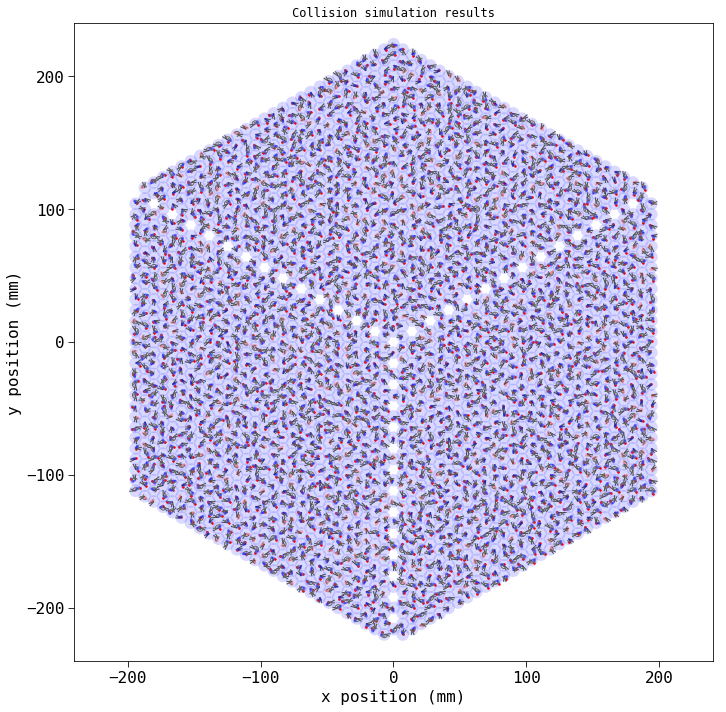

In [78]:
# add flow constraints for colliding cobra pairs

#(problematicCobras,) = np.where(np.logical_and(simulator.collisions, simulator.endPointCollisions == True))
from pfs_netflow.survey_plan import computeStats

from gurobipy import quicksum

import pfs_netflow.datamodel as dm
    
MAXITER = 5

for i in range(MAXITER):
    print("###########################################")
    print("Iteration {} ...".format(i+1))
    print("###########################################")
    ncollisions = OrderedDict()

    for pid in pointings:
        simulator,assignments,cids = getCollSim(g, pid, bench, PLOT=True, ZOOMIN=False)
        ncollisions[pid] = simulator.nCollisions

        if simulator.nCollisions == 0:
            break

        a,b = simulator.bench.cobraAssociations[:,simulator.associationCollisions]

        # identify which flows (e.g. cobra to target assignments) led to collisions
        flow_pairs = []
        for c1,c2 in zip(a,b):
            cid1 = cids[c1]
            cid2 = cids[c2]
            fid1 = "{}_v{}={}_v{}".format( assignments[cid1][0], pid, cids[c1], pid )
            fid2 = "{}_v{}={}_v{}".format( assignments[cid2][0], pid, cids[c2], pid )
            if fid1 in flows and fid2 in flows:
                print(fid1, ": ", g.arcs[fid1].flow, "   ", fid2, ": ", g.arcs[fid2].flow )
                flow_pairs.append((fid1, fid2))
                
    
        #fp = ["T_C017125_vA=C_22_vA", "T_C017269_vA=C_24_vA"] 
        #fp = ["T_C017192_vA=C_30_vA", "T_C017186_vA=C_31_vA"]
        #model.addConstr( quicksum( [ flows[ fp[0] ], flows[ fp[1] ] ] ) <= 1. , "{}_OR_{}".format(fp[0],fp[1]))

        # Add now flow constraints to force the LP solver to choose between either of the two 
        # colliding flows in each collision pair.
        if True: # must be true for iterative collision avoidance to work
            ics_interface.addCollisionFlowConstraints(model, flows, flow_pairs)
           
        ### DEBUGGIN ONLY ####
        #fid1="T_C044677_vA=C_342_vA"
        #fid2="T_C044758_vA=C_344_vA"
        #model.addConstr( quicksum( [ flows[ fid1 ], flows[ fid2 ] ] ) <= 1. , "{}_OR_{}".format(fid1,fid2))
        ###
        
        #for fp in flow_pairs:
        #    if fp[0] in flows and fp[1] in flows:
        #        i += 1
        #        model.addConstr( quicksum( [ flows[ fp[0] ], flows[ fp[1] ] ] ) <= 1. )
        #    elif not fp[0] in flows:
        #        print("No flow variable for {}".format(fp[0]))
        #    elif not fp[1] in flows:
        #        print("No flow variable for {}".format(fp[1]))
        #print("Added {} collision flow constraints.".format(i))

    # Try starts
    if False:    
        flows_sol = model.getAttr('X', flows)
        for k in flows_sol:
                flows[k].start = flows_sol[k]
        #flows[k]

        #for (fid1, fid2) in flow_pairs:
        #    flows[fid1].start = 0
        #    flows[fid2].start = 0

    # Try hints
    if False:
        # set last found solution as hints for the reoptimisation
        flows_sol = model.getAttr('X', flows)
        constr_flows = [ fp[0] for fp in flow_pairs ] + [ fp[1] for fp in flow_pairs ] # list of flows that we just set a constraint on
        for k in flows_sol:
            # don't give hint for flow which we just constrained
            if not k in constr_flows:
                flows[k].VarHintVal = flows_sol[k]
                flows[k].VarHintPri = 10
            else:
                print("Not setting hint for {}.".format(k))
                
        model.write(filename.replace(".mps",".mst"))
                
    # try fix LB/UP outside of vicinity of colliding cobras           
    if False:
        # here we try to fix upper and lower bounds for all TargetPointingToCobraPointingArc
        # to the values of the last solution
        # we then reopen the bounds for cobras only in the vicinity of colliding ones
        #
        # set last found solution as hints for the reoptimisation
        flows_sol = model.getAttr('X', flows)
        constr_flows = [ fp[0] for fp in flow_pairs ] + [ fp[1] for fp in flow_pairs ] # list of flows that we just set a constraint on
        for k in flows_sol:
            a = g.arcs[k]
            if  type(a) == dm.TargetPointingToCobraPointingArc:
                # don't give hint for flow which we just constrained
                if not k in constr_flows:
                    #print("Fixing flow for {} to {}.".format(k, flows_sol[k]) )
                    flows[k].UB = flows_sol[k] # fix flow completely
                    flows[k].LB = flows_sol[k] # fix flow completely
                else:
                    print("Not setting bounds for {}.".format(k))

        # open up flows for all colliding cobras and cobras in their vicinity
        # NOTE: MUST BE FIXED SUCH THTA IT ONLY OPERATES ON THE CURRENT POINTING, I think
        for k in constr_flows:
            if k in g.arcs:
                print("Reopening bounds for{}".format(k))
                a = g.arcs[k]
                n2 = a.endnode
                for a in n2.inarcs:
                    flows[a.id].UB = 1.
                    flows[a.id].LB = 0.
                
    #model.update()
    #model.reset()
    
    #import os
    #if os.path.exists('tmp.sol'):
    #    model.read('tmp.sol')
    
    
    #filename = "mps/{}_{}_{}_{}_colliter{:02d}.mps.gz".format(name, fieldsize, RMAX, NPOINTINGS, i+1)
    #model.write(filename)
    
    #total numer of collisions accross all pointings
    ncoll_total = sum( [v for v in ncollisions.values()])
    if ncoll_total == 0:
        break
    # Re-Solve problem!
    summary += pp("Solving LP problem ...")
    start_time = time.time()
    model.optimize()
    time_to_solve = time.time() - start_time
    summary += pp("Solve status is [{}].".format( model.status ))
    summary += pp("Time to solve: {:.4e} s".format(time_to_solve))
    
    model.write(filename.replace(".mps",".sol"))

    setflows(model, g, flows)
    
    stats = computeStats(g)

    obj = model.getObjective()
    summary += pp("{} = {}".format('Value of cost function', obj.getValue() ) )
    summary += pp("[{}] out of {} science targets get observed.".format(int(stats['NSciObs']) ,NSciTargets) )
    summary += pp("For {} out of these all required exposures got allocated.".format(stats['NSciComplete']))  
    summary += pp("Per target class completion:")

    summary += pp("   {:15s} {:10s} {:10s} {:10s}".format('class', 'total', 'observed', 'completed') )
    for tc,compl in stats['completion'].items():
        summary += pp("   {:15s} {:10d} {:10d} {:10d}".format(tc, compl['total'],compl['observed'],compl['completed']))                                                                       
        #print(tc, compl)                                                                  
    summary += pp("{} targets get sent down the overflow arc.".format(stats['Noverflow']))
    summary += pp("{} out of {} cobras observed a target in one or more exposures.".format(stats['Ncobras_used'], NCobras ))
    summary += pp("{} cobras observed a target in all exposures.".format(stats['Ncobras_fully_used']))

    
    ###
    

In [ ]:
sys.exit(0)

# Plotting 

In [ ]:
if PLOT_SURVEY_PLAN:
    plotSurveyPlan(g)

In [ ]:
if PLOT_FOCAL_PLANE:
    from pfs_netflow.plotting import plotFocalPlane
    for pid in pointings:
        plotFocalPlane(g, pid=pid, W=30, XC=0., YC=0., name="", figsize=[5,5])

In [ ]:
# more detailed per class and per pointing completion analysis
from pfs_netflow.survey_plan import computeCompletion
t = computeCompletion(g, class_dict, "{}_completion.txt".format(name))
t.pprint()

# And plot the results

f = plt.figure(figsize=[10,7])

tclasses = t.keys()[2:]

for tc in tclasses:
    plt.plot(t['N'], t[tc], label='tc', lw=2)
    plt.text(t['N'][-1], t[tc][-1], t[tc][-1])

plt.xlabel('pointing')
plt.ylabel('Cumulative number of observed targets')


In [ ]:
# And plot the results
# reproduce Hayashi san's plot for Umi

def plotKohei(_t):
    f = plt.figure(figsize=[10,7])


    P01to05 = _t['sci_P01'] + _t['sci_P02'] + _t['sci_P03'] + _t['sci_P04'] + _t['sci_P05']
    P06to10 = _t['sci_P06'] + _t['sci_P07'] + _t['sci_P08'] + _t['sci_P09'] + _t['sci_P10']
    PALL = P01to05 + P06to10
    #plt.plot(t['N'], P01to05, drawstyle='steps-mid', label='P01-P05', c='orange')
    #plt.plot(t['N'], P06to10, drawstyle='steps-mid', label='P06-P07', c='purple')

    width = 0.5

    p1 = plt.bar(_t['N'], P01to05, width, fc='purple', label='P01-P05')
    p2 = plt.bar(_t['N'], P06to10, width,
                 bottom=P01to05, fc='orange', label='P06-P07')

    plt.plot(t['N'], PALL, label='all', c='red', lw=2)


    plt.xlabel('pointing')
    plt.ylabel('Cumulative number of observed targets')
    plt.text(_t['N'][-1], P01to05[-1], P01to05[-1])
    plt.text(_t['N'][-1], PALL[-1], PALL[-1])
    plt.xticks([0,6,12,18,24,30,36,42,48])

    plt.xlim([0.,49.5])
    plt.ylim([0.,6000])
    
if name == "GA":
    plotKohei(t)
    plotKohei(t_ETS)


# Routine to generate random target lists

In [ ]:

# make up calibration stars and sky positions
# careful IDs of all objects must be unique!!!
from astropy.table import Table, Column

cal_stars = Table()
sky_pos   = Table()

NSTAR = 400
NSKY  = int( 10000/4. * 0.65)

rr_star = np.random.uniform(size=NSTAR, low=RAmin, high=RAmax)
dd_star = np.random.uniform(size=NSTAR, low=DECmin, high=DECmax)
tt_star = np.ones_like(rr_star) * 900.
pp_star = np.ones_like(rr_star) * 1

cal_stars['ID']        = Column(["F{:06d}".format(i) for i in range(NSTAR)], unit='', description='')
cal_stars['RA']        = Column(rr_star, unit='deg', description='RA')
cal_stars['DEC']       = Column(dd_star, unit='deg', description='DEC')
cal_stars['EXP_TIME']  = Column(tt_star, unit='s', description='Exposure time')
cal_stars['Priority']  = Column(pp_star, unit='', description='Priority', dtype='int')


rr_sky = np.random.uniform(size=NSKY, low=RAmin, high=RAmax)
dd_sky = np.random.uniform(size=NSKY, low=DECmin, high=DECmax)
tt_sky = np.ones_like(rr_sky) * 900.
pp_sky = np.ones_like(rr_sky) * 1

sky_pos['ID']        = Column(["K{:06d}".format(i) for i in range(NSKY)], unit='', description='')
sky_pos['RA']        = Column(rr_sky, unit='deg', description='RA')
sky_pos['DEC']       = Column(dd_sky, unit='deg', description='DEC')
sky_pos['EXP_TIME']  = Column(tt_sky, unit='s', description='Exposure time')
sky_pos['Priority']  = Column(pp_sky, unit='', description='Priority', dtype='int')

#cal_stars.write("pfs_target_list/pfs_preliminary_target_archaeology_umi_fcstars.dat", format="ascii", overwrite=True)
sky_pos.write("pfs_target_list/pfs_preliminary_target_archaeology_umi_fcstars_mock_lowdensity.dat", format="ascii", overwrite=True)

# Model tuning

In [ ]:
if MODEL_TUNING or True:
    model.tune()
    tune_results = []
    for i in range(model.tuneResultCount):
        model.getTuneResult(i)
        model.write("./prm/{}_tune_{:03d}.prm".format(name,i))

    model.getTuneResult(1)

# performance comparison ETS vs. netflow

In [ ]:
len( [class_dict[ID[r]] for r in res] )

In [ ]:
len(ID)

In [ ]:
# Run ETS
from astropy.table import Table, Column


tclasses = [class_dict[id] for id in ID] 
uniq_tclasses = np.unique(tclasses)

def fil(xx,bb):
    """
    Takes a list of objects and a boolean list of same length.
    Retruns a list with all thos object for which the boolean
    input list had a True.
    """
    new = []
    for x,b in zip(xx,bb):
        if b: new.append(x)
    return new


import numpy as np
import time
    
ALGORITHM = "new"
ALGORITHM = "draining"
ALGORITHM = "naive"
ALGORITHM = "draining_closest"

ALL_ALGORITHM = ["new", "draining", "naive", "draining_closest"]

obs_times = np.zeros_like(ID, dtype=float) # will store how much observation time each object recieved
BLOCKTIME = 900.*2.

NPOINTINGS = len(pointings)

for ALGORITHM in ["new"]:
    
    completed = OrderedDict() # will store cumulative list of all targets that got completed
    for tc in tclasses:
        completed[tc] = 0
    
    
    resultfile = "ets_results_{}_{}_{}_{}_{}.txt".format(name, fieldsize, RMAX, NPOINTINGS, ALGORITHM)
    
    print("ALGORITHM {}".format(ALGORITHM))
    NVISISTS = 10
    ii_still_open = np.full_like(ID, True, dtype=bool)

    # set priorities 
    # for cosmology do 1 for claibrators, and 5 for science
    priorities2 = np.array(priorities)
    priorities2[ii_sci] = 5
    priorities2[~ii_sci] = 1
    priorities2 = priorities2.tolist()
    # for GA do 1 for calibrators, and original priority+2 for science, 15 will be "already observed)
    priorities2 = np.array(priorities)
    priorities2[ii_sci] = priorities2[ii_sci] + 2
    priorities2[~ii_sci] = 1
    priorities2 = priorities2.tolist()
    
    # Assemble results in a convenient table
    names = ["N", "pid"] + list(uniq_tclasses)
    
    dtype = ['i4', 'S8'] + ['i4'] * len(list(uniq_tclasses))
    t_ETS = Table(names=names, dtype=dtype)

    
    s = "# algorithm: {}\n".format(ALGORITHM)
    s += "# total number of vistis: {}\n".format(NVISISTS)

    #s += "# total number of observable science targets: {}\n".format(nsci_observable)
    #s += "# total number of observable cal. targets: {}\n".format(ncal_observable)
    #s += "# total number of observable sky positions: {}\n".format(nsky_observable)

    print(s)

    for i,pid in enumerate(pointings):
        #if i == 3:
        #    break
        # reset completion counter for stars and skys as we dont want cumulative number for those
        for tc in uniq_tclasses:
            if "cal" in tc or "sky" in tc:
                completed[tc] = 0 
    

        print("Ponting {}".format(pid))
        print(" Number of remaining targets to observe: {}".format(sum(ii)))

        #print(" Number of remaining cal. targets to observe: {}".format( sum( np.array(types)[ii] == "cal" ) ))
        #print(" Number of remaining sky targets to observe: {}".format( sum( np.array(types)[ii] == "sky" ) ))

        start_time = time.time()
        # perform target assignment using the "draining" algorithm, and return the list
        # of assigned targets and which cobras were used to observe them.
        #res = pyETS.getObs(fil(ets_target_pos,ii),fil(exp_times,ii),fil(priorities,ii),ets_cobras,"draining_closest")
        res = pyETS.getObs(ets_target_pos[pid], exp_times, priorities2, ets_cobras, ALGORITHM)
        time_to_build = time.time() - start_time
        pp(" Time to solve: {:.4e} s".format(time_to_build))

        # figure which out of all potential science targets have been observed
        # and mark them as observed (set very low priority)
        for r in res: 
            # r is the index of a particular object that was picked for observation
            if types[r] == 'sci':
                obs_times[r] = obs_times[r] + BLOCKTIME
            if obs_times[r] > 0. and obs_times[r] < exp_times[r]:
                # object recieved SOME observation but is not finished yet, 
                # set priority to the second highest (after calibration objects)
                priorities2[r] = 2 
                pass
            elif obs_times[r] >= exp_times[r]:
                # object recieved the required observation time,
                # set to lowest priority
                tc = tclasses[r]
                if ii_still_open[r]:
                    completed[tc] = completed[tc] + 1
                    ii_still_open[r] = False # mark as done
                priorities2[r] = 15
            if types[r] == 'cal':
                tc = tclasses[r]
                completed[tc] = completed[tc] + 1
            if types[r] == 'sky':
                tc = tclasses[r]
                completed[tc] = completed[tc] + 1
       
        # compute some statistics
        nsci_observed = sum(np.array(types)[ list(res.keys()) ] == 'sci')
        ncal_observed = sum(np.array(types)[ list(res.keys()) ] == 'cal')
        nsky_observed = sum(np.array(types)[ list(res.keys()) ] == 'sky')
        
        
        print(" Observed {} science targets, {} calibration targets and {} sky positions"\
              .format(nsci_observed, ncal_observed, nsky_observed))
        print("Completed")
        #row = [i, pid, nsci_observed, ncal_observed, nsky_observed, nsci_observed_total]
        #t_ETS.add_row(row)

        row = [i, pid] + [completed[tc] for tc in uniq_tclasses]
        t_ETS.add_row(row)
        
        t_ETS.write(resultfile, overwrite=True, format="ascii.commented_header")
        
        #print(completed)
        
#np.any( np.array(types)[ res.keys() ] == 'cal' )

t_ETS.pprint()

# Plot unobserved targets
from numpy import array
from matplotlib import pyplot as plt
% matplotlib inline
f = plt.figure(figsize=[5,5])

#plt.plot(fil(ra,~ii), fil(dec,~ii), '.', color='k')
plt.plot(fil(ra,ii_still_open), fil(dec,ii_still_open), '.', color='r', alpha=0.1)

plt.ylabel('dec [Deg]')
plt.xlabel('ra [Deg]')
#plt.axis("equal")

#plt.xlim([33.25,34.74])
#plt.ylim([-5.25,-3.75])

In [ ]:
t_ETS

In [ ]:
t

In [ ]:
# And plot the results
# reproduce Hayashi san's plot for Umi

def plotGE(_t, fields = ['sci_P01', 'sci_P02', 'sci_P03', 'sci_P04', 'sci_P05', 'sci_P06']):
    f = plt.figure(figsize=[10,7])
    

    #plt.plot(t['N'], P01to05, drawstyle='steps-mid', label='P01-P05', c='orange')
    #plt.plot(t['N'], P06to10, drawstyle='steps-mid', label='P06-P07', c='purple')

    width = 0.5

    PALL = np.zeros([len(_t)])
    for f in fields: 
        p1 = plt.bar(_t['N'], _t[f], width, bottom=PALL, label=f)
        PALL += _t[f]
                     
    #p1 = plt.bar(_t['N'], PALL, width, fc='orange', label='P01-P06')
    #p2 = plt.bar(_t['N'], P06to10, width,
    #             bottom=P01to05, fc='orange', label='P06-P07')

    plt.plot(t['N'], PALL, label='all', c='red', lw=2)


    plt.xlabel('pointing')
    plt.ylabel('Cumulative number of observed targets')
    #plt.text(_t['N'][-1], P01to05[-1], P01to05[-1])
    plt.text(_t['N'][-1], PALL[-1], PALL[-1])
    #plt.xticks([0,6,12,18,24,30,36,42,48])

    #plt.xlim([0.,49.5])
    plt.legend(loc=2)
    plt.ylim([0.,9000])
    
if name == "GE":
    plotGE(t)
    plt.title('netflow')
    plotGE(t_ETS)
    plt.title('ETS')

In [ ]:
t

In [ ]:
from astropy.io import ascii

nwf_results_npointings = {}
#nwf_results_npointings[12] = ascii.read("nwf_results_npointings12.txt")
#nwf_results_npointings[12] = ascii.read("nwf_results_npointings12.txt")
nwf_results_npointings[10] = ascii.read("nwf_results_npointings10_early_obs1.txt")
#nwf_results_npointings[9] = ascii.read("nwf_results_npointings9.txt")
#nwf_results_npointings[8] = ascii.read("nwf_results_npointings8.txt")
#nwf_results_npointings[7] = ascii.read("nwf_results_npointings7.txt")
#nwf_results_npointings[6] = ascii.read("nwf_results_npointings6.txt")
#nwf_results_npointings[5] = ascii.read("nwf_results_npointings5.txt")
#nwf_results_npointings[4] = ascii.read("nwf_results_npointings4.txt")
#nwf_results_npointings[3] = ascii.read("nwf_results_npointings3.txt")
#nwf_results_npointings[2] = ascii.read("nwf_results_npointings2.txt")

ets_results = {}
ets_results["draining_closest"] = ascii.read("ets_results_draining_closest.txt")
ets_results["draining"] = ascii.read("ets_results_draining.txt")
ets_results["naive"] = ascii.read("ets_results_naive.txt")
ets_results["new"] = ascii.read("ets_results_new.txt")

#ascii.read("ets_results_draining_closest.txt",format

f = plt.figure(figsize=[8,8])

for alg in ets_results:
    plt.plot(ets_results[alg]['V']+1, ets_results[alg]['nsci_total'],'o-', label=alg)

#for npointings in nwf_results_npointings:
#    plt.plot(nwf_results_npointings[npointings]['V']+1, nwf_results_npointings[npointings]['nsci_total'],'ks-', label=alg, color='grey', ms=8)

npointings = 10
plt.plot(nwf_results_npointings[npointings]['V']+1, nwf_results_npointings[npointings]['nsci_total'],'ks-', label="netflow", color='grey', ms=8)

l = plt.legend()
l.draw_frame(False)

plt.axhline(nsci_observable,ls=":",c='k')
plt.text(1,nsci_observable+50,"max # science targets observable".format(nsci_observable),ha='left',va='bottom')
plt.ylabel("# science targets observed")
plt.xlabel("pointing")
plt.ylim([500,8200])

# New & auxiliary stuff

In [ ]:
# Sanity check, make sure all flows are integer:
allflows = []
for a in g.arcs.values():
    k = '{}={}'.format(a.startnode.id,a.endnode.id)
    if k in flows:
        allflows.append(value(flows[k]))

print("All flows are integer: {}".format(all( unique(allflows)%1 == 0 )))


In [ ]:
# This is awsome rescue code. Ever found yourself deleing a call that had a 
# function implemented that you have been working on for hours?
# This is how you recover it.
if False:
    def rescue_code(function):
        import inspect
        get_ipython().set_next_input("".join(inspect.getsourcelines(function)[0]))

    rescue_code(buildSurveyPlan)

# Old stuff, just remaining as backup

In [ ]:
def computeStatsOld(g, flows, cost):
    stats = OrderedDict()

    NSciObs = 0
    NSciComplete = 0
    NCalObs = np.nan
    NCalComplete = np.nan
    NPOINTINGS = len(g.pointings)

    for t in g.sciTargets.values():
        NSciObs += pulp.value(sum([flows[a.id] for a in t.inarcs]))
        NSciComplete += int(sum([pulp.value(flows[a.id]) for a in t.outarcs]) == t.gain)
            
    Noverflow = 0
    for tcid, tc in g.sciTargetClasses.items():
        Noverflow += int( pulp.value(flows['{}=SINK'.format(tcid)]) )

    Ncobras_used = 0
    Ncobras_fully_used = 0
    for c in g.cobras.values():
        v = pulp.value(sum([flows[a.id] for a in c.inarcs]))
        Ncobras_used += int(v > 0)
        Ncobras_fully_used += int(v == NPOINTINGS)
        
    stats['cost'] = pulp.value(cost)
    stats['NSciObs'] = NSciObs
    #stats['NCalObs'] = NCalObs
    stats['NSciComplete'] = NSciComplete
    #stats['NCalComplete'] = NCalComplete
    stats['Noverflow'] = Noverflow
    stats['Ncobras_used'] = Ncobras_used
    stats['Ncobras_fully_used'] =  Ncobras_fully_used
    

    compl = {}
    for stc in g.sciTargetClasses.values():
        _NObs = 0
        _NComplete = 0
        for t in stc.targets.values(): 
            _NObs += int( pulp.value(sum([flows[a.id] for a in t.inarcs])) )
            _NComplete += int(sum([pulp.value(flows[a.id]) for a in t.outarcs]) == t.gain)
            
        compl[stc.ID] = {'total' : len(stc.targets), 'observed' : _NObs, 'completed' : _NComplete}


    stats['completion'] = compl

    return stats


In [ ]:
# Martin's collision detection code

def calc_pairs(loc, maxdist):
    minx = np.min(loc.real)
    maxx = np.max(loc.real)
    miny = np.min(loc.imag)
    maxy = np.max(loc.imag)
    nbx = int((maxx-minx)/maxdist) + 1
    nby = int((maxy-miny)/maxdist) + 1
    bin = [[[] for j in range(nby)] for i in range(nbx)]
    pair = []
    for i in range(len(loc)):
        bx = int((loc[i].real-minx)/maxdist)
        by = int((loc[i].imag-miny)/maxdist)
        bin[bx][by].append(i)
    for bx in range(nbx):
        for by in range(nby):
            pos1 = loc[bin[bx][by]]
            for bx2 in range(max(bx-1,0),min(bx+2, nbx)):
               for by2 in range(max(by-1,0),min(by+2, nby)):
                   pos2 = loc[bin[bx2][by2]]
                   dist = np.abs(np.array(np.subtract.outer(np.array(pos1),np.array(pos2))))
                   for i in range(dist.shape[0]):
                       for j in range(dist.shape[1]):
                           if dist[i][j]<maxdist:
                               i1 = bin[bx][by][i]
                               i2 = bin[bx2][by2][j]
                               if i1<i2:
                                   pair.append((i1,i2))
    return pair

import time
pid = list( pointings.keys() )[0]

targets = target_fplane_pos[pid]

txx = np.array( [t[0] for tid, t in targets.items()] )
tyy = np.array( [t[1] for tid, t in targets.items()] )

print("Starts")
loc = np.array( [complex(x,y) for x,y in zip(txx, tyy)] )

start_time = time.time()

pp = calc_pairs(loc, maxdist=2) 

time_to_finish = time.time() - start_time
print(" Time to completion: {:.2f} s".format(time_to_finish))
    
print( len(pp) , " colliding pairs.")


#for p1id,p2id in pp:
#    print(ID[p1id], ID[p2id])

